In [85]:
import os 
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import torch
import yaml
import torch.nn.functional as F
sns.set(style="whitegrid")

In [102]:
def angular_error_data(exp_results):
    mode_angular = 'cartesian'
    # angular_error_all = {}
    # with open(exp_path, 'rb') as f:
    #     exp_results = pickle.load(f)

    k = 3 if mode_angular == 'cartesian' else 2
    exp_results['frame_pred'] = exp_results['frame_pred'].view(-1, k).numpy()
    exp_results['frame_gt'] = exp_results['frame_gt'].view(-1, k).numpy()
    exp_results['frame_id'] = exp_results['frame_id'].view(-1).numpy()
    exp_results['video_id'] = exp_results['video_id'].view(-1).numpy()
    exp_results['person_id'] = exp_results['person_id'].view(-1).numpy()
    exp_results['data_id'] = exp_results['data_id'].view(-1).numpy()

    with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/Gaze360/gaze360_image_database.pkl', 'rb') as f:
        image_db_gaze360 = pickle.load(f)
    # include the face information in the prediction 
    for k in image_db_gaze360.keys():
        face_info = image_db_gaze360[k]['other']['person_face_bbox']
        is_face = face_info[0] != -1
        image_db_gaze360[k]['face_info'] = 1 if is_face else 0
        gaze_dir = image_db_gaze360[k]['other']['gaze_dir']
        # compute the angular error with center (0,0,-1)
        angular_error = 180/np.pi*np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))
        image_db_gaze360[k]['angular_error'] = angular_error

    # with open('/idiap/temp/pvuillecard/projects/face_analyser/datasets/GFIE/gfie_image_database.pkl', 'rb') as f:
    #     image_db_gfie = pickle.load(f)
    # for k in image_db_gfie.keys():
    #     gaze_dir = image_db_gfie[k]['other']['gaze_direction']
    #     # compute the angular error with center (0,0,-1)
    #     angular_error = 180/np.pi*np.arccos(np.dot(gaze_dir, np.array([0, 0, -1])) / (np.linalg.norm(gaze_dir) * np.linalg.norm(np.array([0, 0, -1]))))
    #     image_db_gfie[k]['angular_error'] = angular_error

    pred_gaze360 = {}
    for i in range(len(exp_results['frame_id'])):
        if exp_results['data_id'][i] == 1:
            pred_gaze360[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
                'frame_pred': exp_results['frame_pred'][i],
                'frame_gt': exp_results['frame_gt'][i]
            }
    if len(pred_gaze360) > 0:
        # gaze 360 error

        for k in pred_gaze360.keys():
            
            gt = torch.from_numpy(pred_gaze360[k]['frame_gt']).unsqueeze(0)
            pred = torch.from_numpy(pred_gaze360[k]['frame_pred']).unsqueeze(0)
        
            input_cart = F.normalize(pred, p=2, dim=1)
            target_cart = F.normalize(gt, p=2, dim=1)
            

            sim = F.cosine_similarity(input_cart, target_cart, dim=1, eps=1e-10)
        
            output_dot = torch.acos(sim)*180/np.pi
            image_db_gaze360[k]['angular_error_prediction'] = output_dot[0].item()
            image_db_gaze360[k]['angular_cosine'] = sim[0].item()


    # pred_gifie = {}
    # for i in range(len(exp_results['frame_id'])):
    #     if exp_results['data_id'][i] == 2:
    #         pred_gifie[f'clip_{exp_results["video_id"][i]:08d}_frame_{exp_results["frame_id"][i]:08d}'] = {
    #             'frame_pred': exp_results['frame_pred'][i],
    #             'frame_gt': exp_results['frame_gt'][i]
    #         }
    # angular_error_full = AngularError(mode = mode_angular)
    # angular_error_180 = AngularError(mode = mode_angular)
    # angular_error_20 = AngularError(mode = mode_angular)

    # if len(pred_gifie) > 0:
    #     for k in pred_gifie.keys():
            
    #         gt = pred_gifie[k]['frame_gt']
    #         pred = pred_gifie[k]['frame_pred']
    #         image_db_gfie[k]['angular_error_prediction'] = 180/np.pi*np.arccos(np.dot(gt, pred)) / (np.linalg.norm(gt) * np.linalg.norm(pred))

    # pred_mpsgaze = {}
    # for i in range(len(exp_results['frame_id'])):
    #     if exp_results['data_id'][i] == 3:
    #         pred_mpsgaze[f'frame_{exp_results["frame_id"][i]:08d}_face_{exp_results["person_id"][i]:08d}'] = {
    #             'frame_pred': exp_results['frame_pred'][i],
    #             'frame_gt': exp_results['frame_gt'][i]
    #         }

    # angular_error_full = AngularError(mode = mode_angular)
    # angular_error = { 30*i: AngularError(mode = mode_angular) for i in range(1, 9)}

    # for k in pred_mpsgaze.keys():
    #     face_size = image_db_mpsgaze[k]['face_size']
    #     angular_error_full.update(torch.from_numpy(pred_mpsgaze[k]['frame_gt']).unsqueeze(0),
    #                         torch.from_numpy(pred_mpsgaze[k]['frame_pred']).unsqueeze(0))
    #     if face_size is not None:
    #         angular_error[face_size].update(torch.from_numpy(pred_mpsgaze[k]['frame_gt']).unsqueeze(0),
    #                         torch.from_numpy(pred_mpsgaze[k]['frame_pred']).unsqueeze(0))

    # angular_error_all[f"MPSGaze_all"] = angular_error_full.compute()
    # for k in angular_error.keys():
    #     angular_error_all[f"MPSGaze_{k}"] = angular_error[k].compute()

    gaze360_df = pd.DataFrame.from_dict(image_db_gaze360, orient='index')
    # drop nan
    gaze360_df = gaze360_df.dropna()
    gaze360_df['20'] = gaze360_df['angular_error'] <= 20
    gaze360_df['180'] = gaze360_df['angular_error'] <= 90
    gaze360_df['back'] = gaze360_df['angular_error'] > 90
    def define_group(x):
        if x['20']:
            return '20'
        elif x['180']:
            return '180'
        else:
            return 'back'
    gaze360_df['group'] = gaze360_df.apply(define_group, axis=1)
    return gaze360_df

def plot_visualization(all_results):
    fig , ax = plt.subplots(2, 5, figsize=(20, 10), sharey=True, sharex=True)

    for i in range(len(all_results)):
        sns.histplot(data=all_results[i], x='angular_error_prediction',hue='group', bins=50, kde=True, ax=ax[i//5, i%5])
        ax[i//5, i%5].set_title(f'Head size ratio: {all_results[i]["head_ratio"].values[0]}')
        ax[i//5, i%5].set_xlim([0, 90])
        ax[i//5, i%5].set_xlabel('Angular error (deg)')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True, sharex=True)
    head_ratios = []
    for i in range(len(all_results)):
        head_ratio = all_results[i]['head_ratio'].values[0]
        head_ratios.append(head_ratio)
        sns.regplot(data=all_results[i], x='angular_error', y='angular_error_prediction', ci=95,scatter=False, ax=ax,label=f'{head_ratio}')
        
    ax.legend()
    ax.set_title('Angular error at different gaze direction and head size ratio')
    ax.set_ylabel('Angular error (deg)')
    ax.set_xlabel('Gaze direction (deg)')

In [103]:
all_results = []
for i in range(10):
    run_id = i
    path = f'/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/gaze360_head_size/run_2024-06-16_20-27-24/logs/train/runs/run_{run_id}'
    epoch = 50

    test_dir = os.path.join(path, 'metric', 'test')
    test_file = [ f for f in os.listdir(test_dir) if f.endswith('.pkl') ][0]

    with open(os.path.join(test_dir, test_file), 'rb') as f:
        exp_results = pickle.load(f)

    with open(os.path.join(path, '.hydra','config.yaml'), 'r') as f:
        config = yaml.safe_load(f)

    head_ratio = config['extras']['bbox_scale_ratio']

    gaze360_df = angular_error_data(exp_results)
    gaze360_df['head_ratio'] = head_ratio
    all_results.append(gaze360_df)

all_results_aggregate = pd.concat(all_results)


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

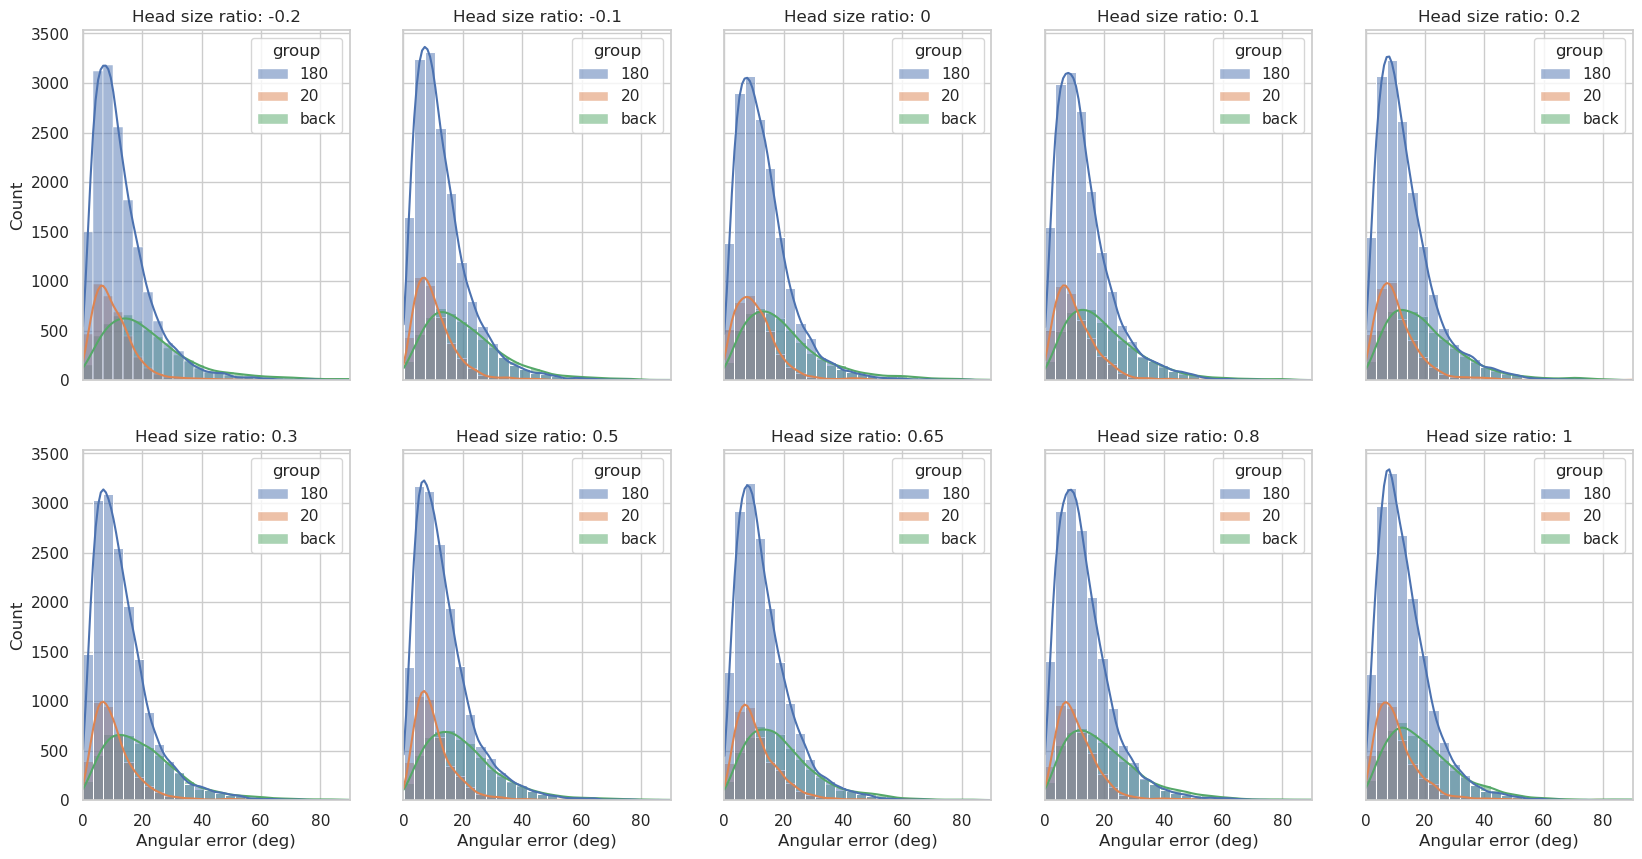

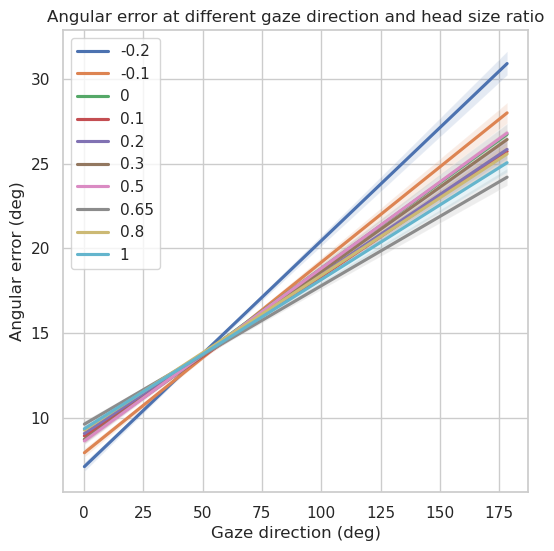

In [104]:
plot_visualization(all_results)


/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/idiap/temp/pvuillecard/miniconda3/envs/uniface/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: F

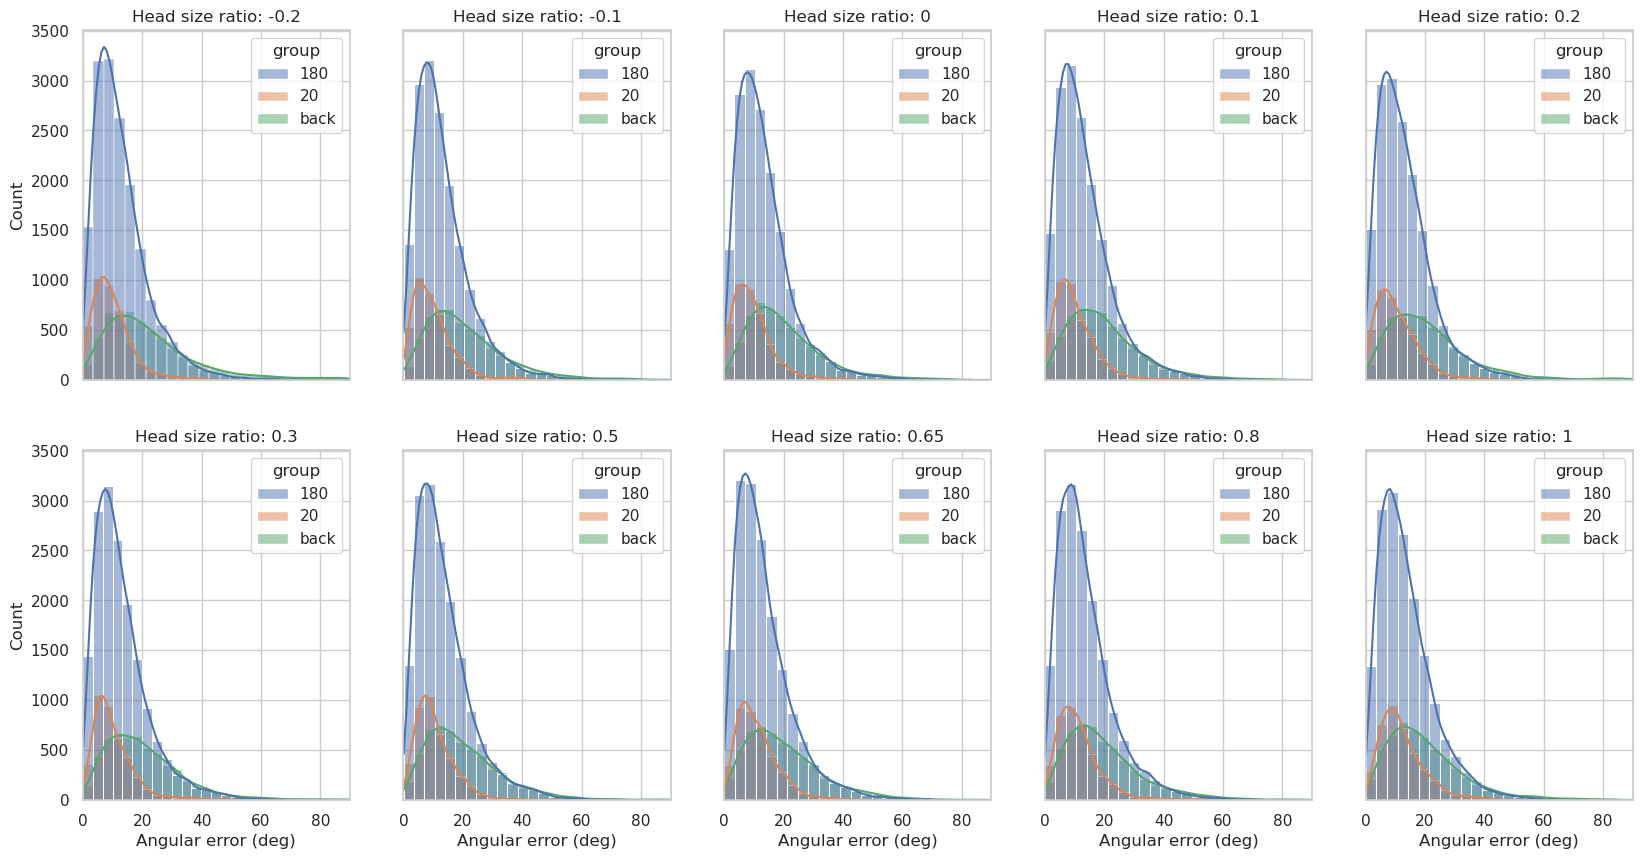

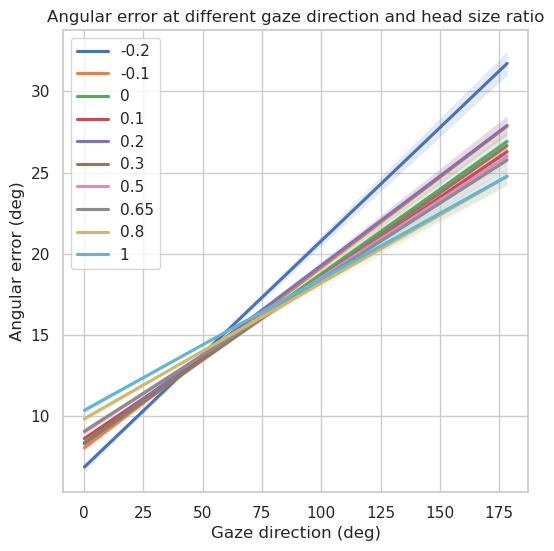

In [105]:

all_results = []
for i in range(10):
    run_id = i
    path = f'/idiap/temp/pvuillecard/projects/gaze_pretrain/logs/experiments/gaze360_head_size/run_2024-06-14_16-55-45/logs/train/runs/run_{run_id}'
    epoch = 50

    test_dir = os.path.join(path, 'metric', 'test')
    test_file = [ f for f in os.listdir(test_dir) if f.endswith('.pkl') ][0]

    with open(os.path.join(test_dir, test_file), 'rb') as f:
        exp_results = pickle.load(f)

    with open(os.path.join(path, '.hydra','config.yaml'), 'r') as f:
        config = yaml.safe_load(f)

    head_ratio = config['extras']['bbox_scale_ratio']

    gaze360_df = angular_error_data(exp_results)
    gaze360_df['head_ratio'] = head_ratio
    all_results.append(gaze360_df)

plot_visualization(all_results)